# MCMC sampling diagnostics

In this notebook, we illustrate how to assess the quality of your MCMC samples, e.g. convergence and auto-correlation, implemented in pyPESTO.

## The pipeline

First, we show a typical workflow, fully integrating the samplers with a [PEtab](https://github.com/petab-dev/petab) problem, using a toy example of a conversion reaction.

In [1]:
import pypesto
import petab
import numpy as np

# import to petab
petab_problem = petab.Problem.from_yaml(
    "conversion_reaction/conversion_reaction.yaml")
# import to pypesto
importer = pypesto.PetabImporter(petab_problem)
# create problem
problem = importer.create_problem()

In [2]:
sampler = pypesto.AdaptiveParallelTemperingSampler(
    internal_sampler=pypesto.AdaptiveMetropolisSampler(),
    n_chains=3)

First, we will initiate the MCMC chain at a "random" point in parameter space, e.g. $\theta_{start} = [3, -4]$

In [3]:
result = pypesto.sample(problem, n_samples=10000, sampler=sampler, x0=np.array([3,-4]))

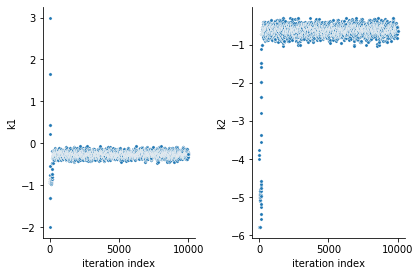

In [4]:
ax = pypesto.visualize.sampling_parameters_trace(result, use_problem_bounds=False)

By visualizing the chains, we can see a warm up phase occurring until convergence of the chain is reached. This is commonly known as "burn in" phase and should be discarded. An automatic way to evaluate and find the index of the chain in which the warm up is finished can be done by using the Geweke test.

Geweke Burn-in index: 500


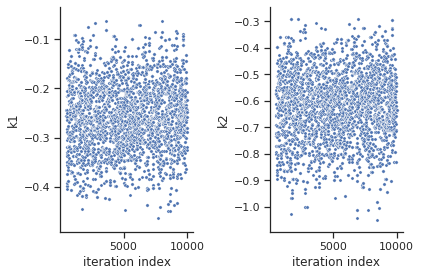

In [5]:
burn_in = pypesto.sampling.GewekeTest(result=result)
ax = pypesto.visualize.sampling_parameters_trace(result, use_problem_bounds=False, burn_in=burn_in)

In [6]:
ac = pypesto.sampling.ChainAutoCorrelation(result=result, burn_in=burn_in)
print(ac)

[8.17636663 8.39123416]


In [7]:
ess = pypesto.sampling.EffectiveSampleSize(result=result, burn_in=burn_in)
print('Effective sample size: '+str(ess))

Effective sample size: 1011.6881163089345


Commonly, as a first step, optimization is performed, in order to find good parameter point estimates.

In [8]:
res = pypesto.minimize(problem, n_starts=10)

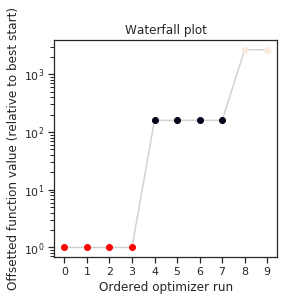

In [9]:
ax = pypesto.visualize.waterfall(res, size=(4,4))

Next, we perform sampling. Here, we employ a `pypesto.sample.AdaptiveParallelTemperingSampler` sampler, which runs Markov Chain Monte Carlo (MCMC) chains on different temperatures. For each chain, we employ a `pypesto.sample.AdaptiveMetropolisSampler`. For more on the samplers see below or the API documentation.

For the actual sampling, we call the `pypesto.sample` function. By passing the result object to the function, the previously found global optimum is used as starting point for the MCMC sampling.

In [10]:
res = pypesto.sample(problem, n_samples=10000, sampler=sampler, result=res)

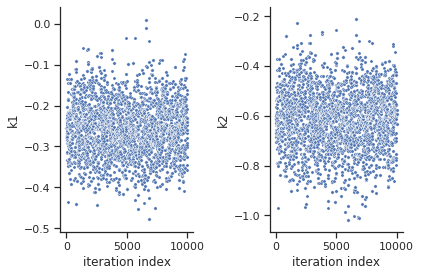

In [11]:
ax = pypesto.visualize.sampling_parameters_trace(res, use_problem_bounds=False)

When the sampling is finished, we can analyse our results. pyPESTO provides functions to analyse both the sampling process as well as the obtained sampling result. Visualizing the traces e.g. allows to detect burn-in phases, or fine-tune hyperparameters. First, the parameter trajectories  can be visualized:

Geweke Burn-in index: 0


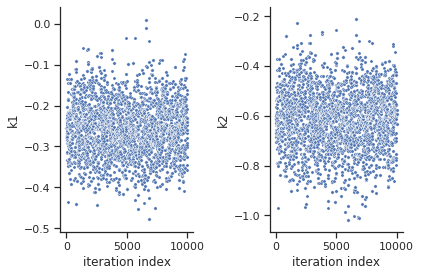

In [12]:
burn_in = pypesto.sampling.GewekeTest(result=res)
ax = pypesto.visualize.sampling_parameters_trace(res, use_problem_bounds=False, burn_in=burn_in)

In [13]:
ac = pypesto.sampling.ChainAutoCorrelation(result=res, burn_in=burn_in)
print(ac)

[7.09094534 7.54918959]


In [14]:
ess = pypesto.sampling.EffectiveSampleSize(result=res, burn_in=burn_in)
print('Effective sample size: '+str(ess))

Effective sample size: 1169.8184837556216
